## **1. Get Data**

The dataset we will be using for this is a subset of the Food101 dataset. The original Food101 dataset has 101 food categories and 1000 images for each class(750 for training, 250 for testing)

Our dataset here has 3 classes of foods and only 10% of the images (~75 training and 25 testing)

We do so because starting out ML projects, its important to try things on a small scale and then increase the scale when necessary. This will help us speed up our experiments as well.

In [1]:
import torch
from torch import nn

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path=Path("data/")
image_path=data_path/ "pizza_steak_sushi"

# If the image folder doesnt exist , download it print it

if image_path.is_dir():
    print(F"{image_path} directory already exists...skipping download")
else:
    print(f"{image_path} does not exist, creating one..")
    image_path.mkdir(parents=True,exist_ok=True)

# Download
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    # this link should have raw/blob not main/blob
    print("Downloading pizza, steak and sushi data")
    f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data")
    zip_ref.extractall(image_path)



data\pizza_steak_sushi directory already exists...skipping download
Unzipping pizza, steak and sushi data


### **2. Data preparation and exploration**

In [3]:
import os
def walk_through_data(dir_path):
    """
    Walks through dir_path returning its contents
    """
    for dirpath, dirnames , filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [4]:
walk_through_data(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 46 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 58 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 46 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 154 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 146 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 150 images in data\pizza_steak_sushi\train\sushi


In [5]:
# Setup training and testing paths
train_dir=image_path / "train"
test_dir=image_path / "test"

train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### **2.1 Visualizing image**

Lets write some code to :
1. Get all of image paths
2. Pick a random image path using pythons random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Open the image using python's PIL
5. Display the image and print metadata

data\pizza_steak_sushi\train\sushi\307738.jpg
sushi
Random image path:data\pizza_steak_sushi\train\sushi\307738.jpg
Image class : sushi
Image height : 382
Image width : 512


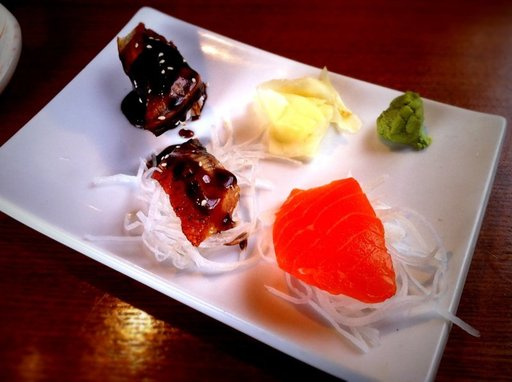

In [6]:
import random
from PIL import Image

#random.seed(42)

# Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path=random.choice(image_path_list)
print(random_image_path)

# Get image class from path name (the image is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem
print(image_class)

# Open image
img=Image.open(random_image_path)

# Print metadata
print(f"Random image path:{random_image_path}")
print(F"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img


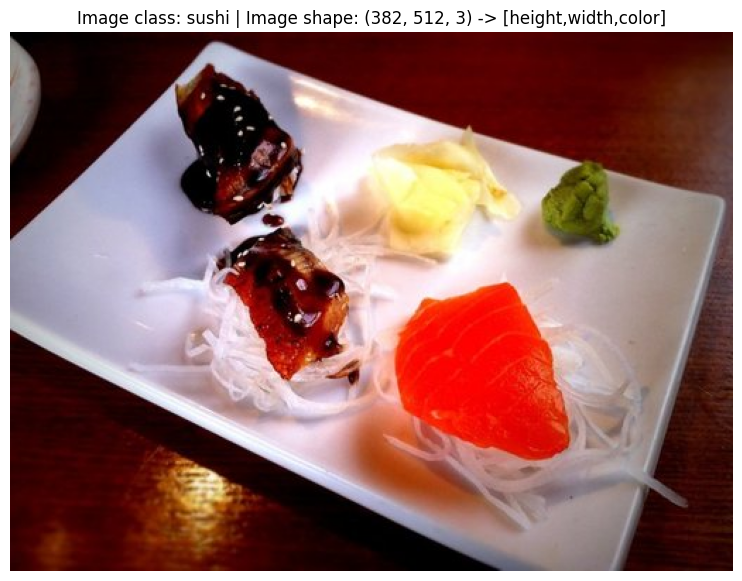

In [7]:
# Visualizing image using matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into array
img_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color]")
plt.axis(False);


### **3.Transforming Data**

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images)
2. Turn it into a,  `torch.utils.data.Dataset` and subsequently a `torch.utils.DataLoader` , we'll call these `Dataset` and `DataLoader`


In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### **3.1 Transforming data with torchvision.transforms**

Transforms help you get your images ready to be used with a model or perform data augmentation

In [9]:
# Write a transform for image
data_transform=transforms.Compose([
    # Resize our image
    transforms.Resize(size=(64,64)),
    # FLip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # 50% times when images pass through this it will flip it
    # Turn the image into tensor
    transforms.ToTensor()
])

In [10]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [11]:
data_transform(img).dtype

torch.float32

In [12]:
# Code to visualize batch of images
"""We have image_path_lists which has some random image paths
, we are going to pass few of these random images , transform them 
and try to visualize what the original and transformed image look like
"""
def plot_transformed_images(image_paths,transform,n=3,seed=None):
    """
    Selects random images from a path of images and loads/transforms them then 
    plots the original vs transformed images
    """
    if seed:
        random.seed(seed)
    random_image_paths=random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax=plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image=transform(f).permute(1,2,0)# note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(F"Transformed\nShape:{transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

            

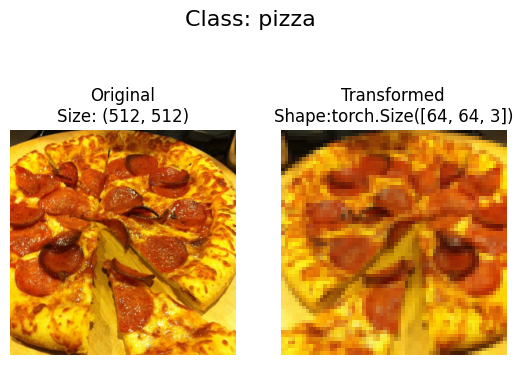

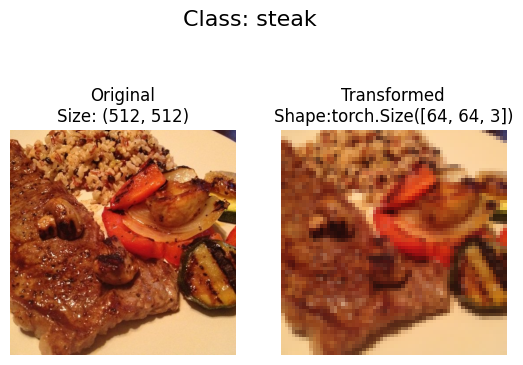

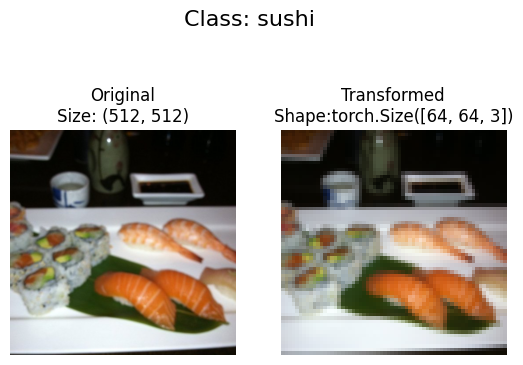

In [13]:
plot_transformed_images(image_paths=image_path_list,transform=data_transform,
                        n=3)

### **4. Option 1: Loading image data through `ImageFolder`**

We can load image classification data using `torchvision.dataasets.ImageFolder`


In [14]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,transform=data_transform, # Transform for data
                                target_transform=None)   # Transform for labels/targets

test_data=datasets.ImageFolder(root=test_dir,transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dictionary
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the length of dataset
len(train_data),len(test_data)

(450, 150)

In [18]:
# Visualize some samples from train_data

# Index on train_data Dataset to get a single image and label
img,label=train_data[0][0],train_data[0][1]
print(f"Image tensor: {img}")
print(F"Image shape: {img.shape}")
print(f"Image datatype:{img.dtype}")
print(F"Image label: {label}")
print(F"Label type:{type(label)}")

Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape:torch.Size([3, 64, 64]) ->[color_channels, height,width]
Image permute :torch.Size([64, 64, 3]) -> [height,width,color_channels]


Text(0.5, 1.0, 'pizza')

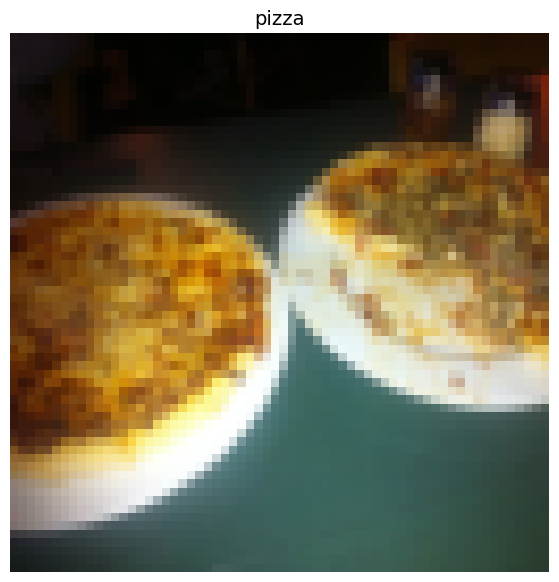

In [19]:
# Rearrange the order dimensions

img_permute=img.permute(1,2,0)

# Print out different shapes
print(f"Original shape:{img.shape} ->[color_channels, height,width]")
print(f"Image permute :{img_permute.shape} -> [height,width,color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

### **4.1 Turn loaded images into DataLoaders**

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time

In [20]:
# Turn train and etst datasets intoo DataLoaders

from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,num_workers=1,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,num_workers=1,shuffle=False)

train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x1db771473a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1db77147fa0>)

In [21]:
len(train_dataloader),len(test_dataloader)

(450, 150)

In [22]:
img,label=next(iter(train_dataloader))

#Batch size will now be 1, you can change batch size if you like

print((F"Image shape: {img.shape} -> [batch_size,color_channels,height,width]"))
print(F"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size,color_channels,height,width]
Label shape: torch.Size([1])


## **4. Option 2 : Loading Image daat with custom dataset**

1. Want to be able to load images from file
2. Want to be able to get class names from Dataset
3. Want to be able to get classes as dictionary from the Dataset


Pros:
* Create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything , it doesnt mean it will work..
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues


All custom datasets in PyTorch subclass `torch.utils.data.Dataset`

In [23]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List



In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### **5.1 Creating a helper function to get class names**

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format)

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)

3. Turn the class names into a dict and a list and return them


In [25]:
# Setup path for target directory
target_directory=train_dir
print(f"Target dir: {target_directory}")

# Get the class names from targeted directory
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory:str)->Tuple[List[str],Dict[str,int]]:
    """
    Finds the class folder namess in target directory
    """
    # Get class names by scanning directory
    classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # Raise error if class name could not be found
    if not classes:
        print(f"Couldnt find any class in {directory} please check file structure")
    class_to_idx={class_name: i for i , class_name in enumerate(classes)}
    return classes,class_to_idx


This function replicates the ImageFolder functionality

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### **5.2 Create a custom `Dataset` to replicate ImageFolder**

To create our own custom dataset, we want to :

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data
3. Create several attributes:
    * paths-paths of our images
    * transform- the transform we'd like to use
    * classes- a list of target classes
    * class_to_idx- a dict of the target classes mapped to integer labels
4. Create a function to `load_images()` , this function will open an image
5. Overwrite the `__len()__` method to return length of dataset
6. Overwrite the `__getitem()__` method to return a given sample when passes on index

In [28]:
#  Write a custom dataset
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # Initialise custom dataset
    def __init__(self,targ_dir:str,transform=None):
        # Create class attributes 
        # Get all image paths
        self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform=transform
        # Create classes and class_to_idx attributes
        self.classes,self.class_to_idx=find_classes(targ_dir)
    def load_image(self,index:int):
        """
        Opens an image via a path and returns it
        """
        image_path=self.paths[index]
        return Image.open(image_path)
    def __len__(self) -> int:
        """
        Returns the total number of samples
        """
        return len(self.paths)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns one sample of data, data and label(X,y)
        """
        img=self.load_image(index)
        class_name=self.paths[index].parent.name # expects path in format:data_folder/class_name/image.jpg
        class_idx=self.class_to_idx[class_name]
        
        #Transform if necessary
        if self.transform:
            return self.transform(img),class_idx
        else:
            return img,class_idx


In [29]:
# Create a transform
from torchvision import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom

train_data_custom=ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)

test_data_custom=ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

In [31]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x1db771614e0>,
 <__main__.ImageFolderCustom at 0x1db77160d30>)

In [32]:
len(train_data),len(train_data_custom)

(450, 450)

In [33]:
len(test_data),len(test_data_custom)

(150, 150)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset

print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### **5.3 Create a function to display random images**

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display setting getting out of hand, lets cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from target dataset
5. Setup a matplotlib plot
6. Loop through random samples indexes and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [37]:
# Create a function to take in a datset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n:int =10,
                          display_shape:bool=True,
                          seed:int=None):
    # Adjust display if n is too high
    if n>10:
        n=10
        display_shape=False
        print(f"For display purposes n shouldnt be larger than 10")

    # Set the seed
    if seed:
        random.seed(seed)
    
    # Get random sample indexes
    random_sample_idx=random.sample(range(len(dataset)),k=n)

    # Setup plot
    plt.figure(figsize=(16,8))

    # Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate (random_sample_idx):
        targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]
        # Adjust tensor dimensions for plotting
        targ_image_adjust=targ_image.permute(1,2,0)

        # Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title=f"Class: {classes[targ_label]}"
            if display_shape:
                title=title+f"\Shape: {targ_image_adjust.shape}"
        plt.title(title)

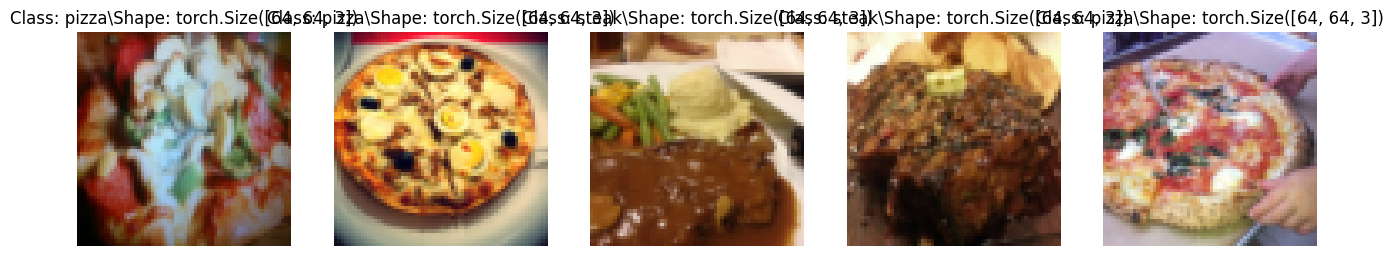

In [38]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data
                       ,classes=class_names
                       ,n=5,seed=None)

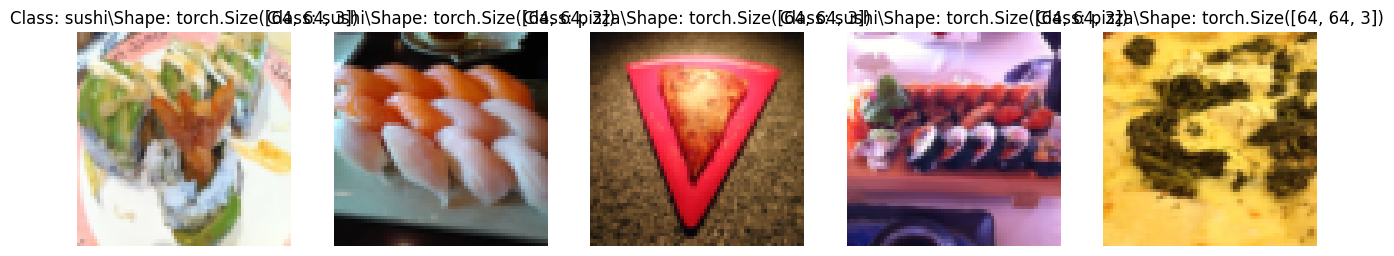

In [39]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,n=5,classes=class_names,seed=None)

### **5.4 Turn custom  loaded images into DataLoaders**

In [40]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=BATCH_SIZE,
                                   num_workers=0,shuffle=True)

test_dataloader_custom=DataLoader(dataset=test_data_custom,batch_size=BATCH_SIZE,
                                   num_workers=0,shuffle=False)

train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1db77163f10>,
 <torch.utils.data.dataloader.DataLoader at 0x1db771da020>)

In [41]:
# Get image and label from custom dataloader

img_custom,label_custom=next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### **6. Other forms of transforms (data augmentation)**

Data augmentation is the process of artificially adding diversity to your training data.

In case of image data, this may mean various image transformations to the training images

It basically involves looking at the same image but from different perspectives (like rotating, cropping, shifting etc), to artificially increase diversity of dataset

This practice hopefully results in a model thats more generalizable to unseen data

Lets take a look at one particular type of data augmentation used to train PyTorch:

In [42]:
# Lets take a look at TrivialAugment

from torchvision import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms=transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.ToTensor()
])

In [43]:
# Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]


[WindowsPath('data/pizza_steak_sushi/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1315645.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/138961.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/148765.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1555015.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1618659.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg')]

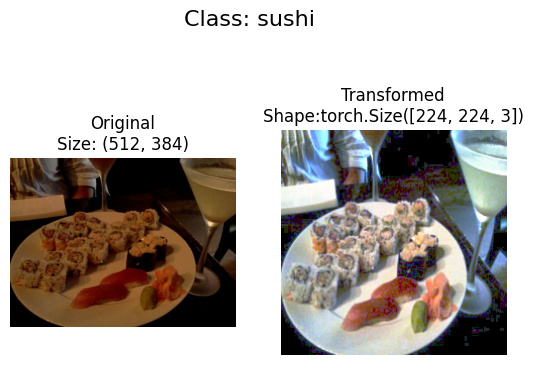

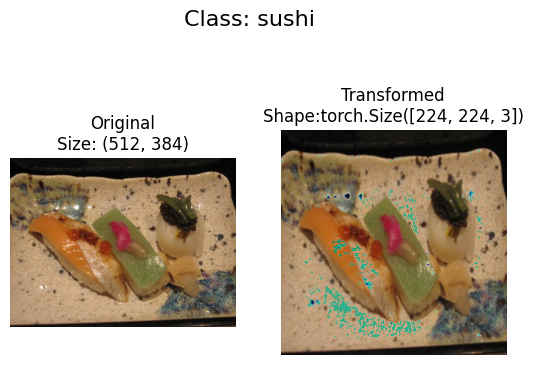

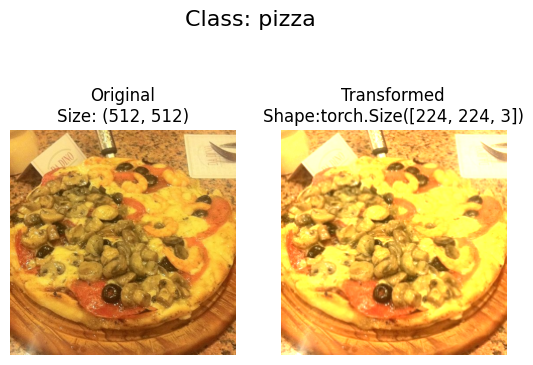

In [44]:
# Plot random transformed images

plot_transformed_images(image_paths=image_path_list,transform=train_transforms,n=3,seed=None)


### **7. Model 0: TinyVGG wihtout data augmentation**

Lets replicate the TinyVGG architecture from CNN Explainer website 

### **7.1 Create transforms and loading data from Model 0**

In [45]:
# Create a simple transform

simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [46]:
# Load and transform data
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir,transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,transform=simple_transform)

# Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

# Create DataLoaders
train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)


### **7.2 Create TinyVGG Model Class**

In [47]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """

    def __init__(self, input_shape:int,
                 hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    def forward(self,x):
        x=self.conv_block_1(x)
        #print(x.shape)
        x=self.conv_block_2(x)
        #print(x.shape)
        x=self.classifier(x)
        return x

In [48]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3, # number of color channels in our image data
            hidden_units=10,output_shape=len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### **7.3 Try a forward pass on a single image**

In [49]:
# Pass some dummy data into forward model to check if the input shapes are lined up

# Get a single image batch
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
model_0(image_batch)

tensor([[ 0.0212, -0.0040,  0.0116],
        [ 0.0190, -0.0012,  0.0085],
        [ 0.0224, -0.0014,  0.0080],
        [ 0.0206, -0.0046,  0.0091],
        [ 0.0220, -0.0016,  0.0100],
        [ 0.0195,  0.0004,  0.0091],
        [ 0.0230, -0.0043,  0.0122],
        [ 0.0182,  0.0006,  0.0116],
        [ 0.0200,  0.0003,  0.0093],
        [ 0.0200,  0.0005,  0.0105],
        [ 0.0212, -0.0030,  0.0087],
        [ 0.0205, -0.0024,  0.0106],
        [ 0.0206, -0.0038,  0.0112],
        [ 0.0191, -0.0022,  0.0070],
        [ 0.0214, -0.0030,  0.0086],
        [ 0.0169,  0.0044,  0.0053],
        [ 0.0243, -0.0032,  0.0113],
        [ 0.0220,  0.0004,  0.0114],
        [ 0.0183,  0.0006,  0.0094],
        [ 0.0203,  0.0026,  0.0086],
        [ 0.0207, -0.0012,  0.0097],
        [ 0.0208, -0.0029,  0.0089],
        [ 0.0198, -0.0023,  0.0090],
        [ 0.0203, -0.0028,  0.0091],
        [ 0.0191, -0.0002,  0.0105],
        [ 0.0210, -0.0054,  0.0107],
        [ 0.0207,  0.0014,  0.0075],
 

### **7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [51]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [52]:
from torchinfo import summary

summary(model_0,input_size=[1,3,64,64])  # input size is input of the data we wil be passing through

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### **7.5 Create train and test loops function**

* `train_step()`- takes in a model and dataloader and trains the model on the dataloader

* `test_step()`- takes in a model and dataloader and evaluates the model on the dataloader


In [53]:
device="cpu"

In [54]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [55]:

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### **7.6 Creating a `train()` function to combine `train_step()` and `test_step()`**

In [56]:
from tqdm.auto import tqdm

# Create a train function that takes in parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn:torch.nn.Module= nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device
          ):
    # Create empty results dict
    results={"train_loss": [],"train_acc" : [], "test_loss" :[],"test_acc":[]
             }
    #Loop through training and testing steps 
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,dataloader=train_dataloader,
                                        loss_fn=loss_fn,optimizer=optimizer)
        test_loss,test_acc=test_step(model=model,dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train acc: {train_acc} | Test Loss:{test_loss} | Test acc:{test_acc}")
        
        # Update results dictionary
        results["train_loss"].append(train_loss)  
        results["train_acc"].append(train_acc)    
        results["test_loss"].append(test_loss) 
        results["test_acc"].append(test_acc)      

        # return filled results
    return results  


### **7.7 Train and evaluate model_0**


In [57]:
torch.manual_seed(42)

NUM_EPOCHS=5
model_0=TinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data.classes))
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),lr=0.001)

from timeit import default_timer as timer
start_timer=timer()

model_0_results=train(model=model_0,train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,optimizer=optimizer,
                      loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time=timer()

print(F"Total training time : {end_time-start_timer:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1046583573023478 | Train acc: 0.3145833333333333 | Test Loss:1.0971670866012573 | Test acc:0.2875
Epoch: 1 | Train Loss: 1.0885716358820596 | Train acc: 0.39791666666666664 | Test Loss:1.07392315864563 | Test acc:0.42897727272727276
Epoch: 2 | Train Loss: 1.055297807852427 | Train acc: 0.49375 | Test Loss:1.040929114818573 | Test acc:0.4727272727272728
Epoch: 3 | Train Loss: 0.9824737191200257 | Train acc: 0.5333333333333333 | Test Loss:0.9782142400741577 | Test acc:0.5454545454545454
Epoch: 4 | Train Loss: 0.9820996562639872 | Train acc: 0.48541666666666666 | Test Loss:0.9347520351409913 | Test acc:0.5505681818181818
Total training time : 78.204 seconds


In [58]:
model_0_results

{'train_loss': [1.1046583573023478,
  1.0885716358820596,
  1.055297807852427,
  0.9824737191200257,
  0.9820996562639872],
 'train_acc': [0.3145833333333333,
  0.39791666666666664,
  0.49375,
  0.5333333333333333,
  0.48541666666666666],
 'test_loss': [1.0971670866012573,
  1.07392315864563,
  1.040929114818573,
  0.9782142400741577,
  0.9347520351409913],
 'test_acc': [0.2875,
  0.42897727272727276,
  0.4727272727272728,
  0.5454545454545454,
  0.5505681818181818]}

###  **7.8 Plotting loss curves of Model 0**

A loss curve is a way of tracking your models progress over time


In [59]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [60]:
def plot_loss_curves(results: Dict[str,List[float]]):
    """
    Plots training curves of a results dictionary
    """
    loss=results["train_loss"]
    test_loss=results["test_loss"]
    accuracy=results["train_acc"]
    test_accuracy=results["test_acc"]
    epochs=range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label="train_loss")
    plt.plot(epochs,test_loss,label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    

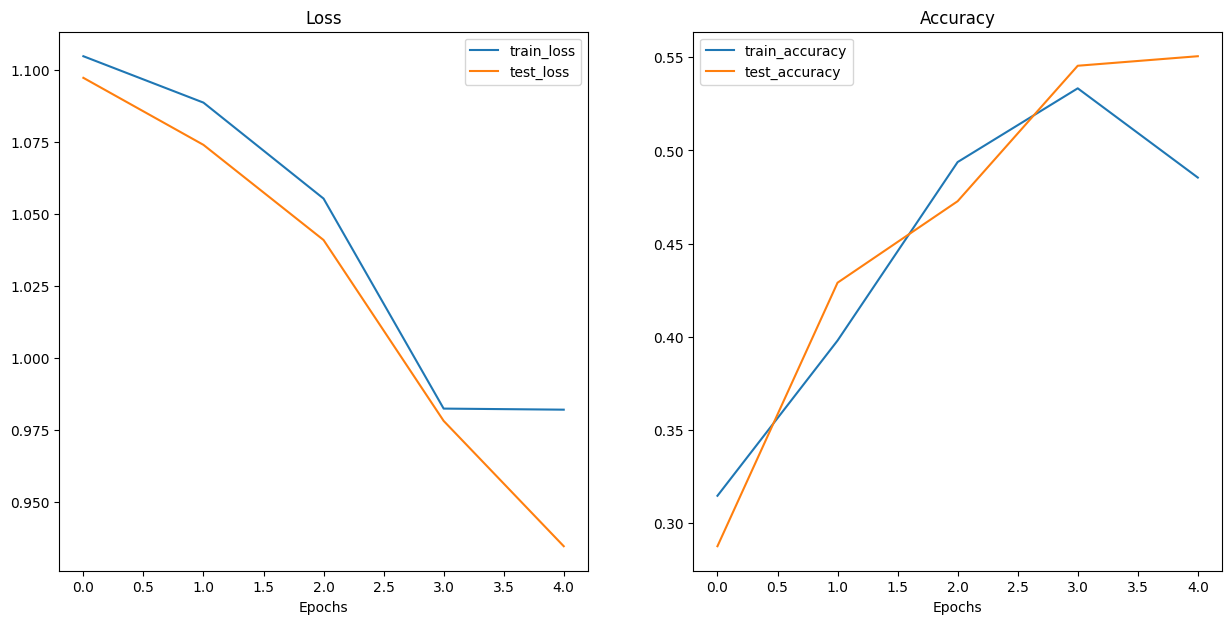

In [61]:
plot_loss_curves(model_0_results)

### **8. What should an ideal loss curve look like?**

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### **8.1 How to deal with overfitting**

Since the main problem with overfitting is that your model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).


Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. | 
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. | 
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

### **8.2 How to deal with underfitting **

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. | 
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### **8.3 The balance between overfitting and underfitting**

None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everyone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

### **9. Model 1: TinyVGG with data augmentation**

This time lets try to build TinyVGG, by loading data and then use data augmentation to see if it can give us better results

### **9.1 Create transform with data augmentation**

In [62]:
# Craete training transform with trivialaugment

train_transform_trivial_augment=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform without augmentation

test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

### **9.2 Create train and test `Datasets` and `DataLoaders`


In [63]:
train_data_augmented=datasets.ImageFolder(train_dir,transform=train_transform_trivial_augment,
                                          )
test_data_simple=datasets.ImageFolder(test_dir,transform=test_transform)
train_data_augmented,test_data_simple

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [64]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1db70e15990>,
 <torch.utils.data.dataloader.DataLoader at 0x1db77147fa0>)

### **9.3 Construct and train Model 1**

In [65]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [66]:
# Set random seeds
torch.manual_seed(42) 

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1015397707621257 | Train acc: 0.3104166666666667 | Test Loss:1.1017300963401795 | Test acc:0.2875
Epoch: 1 | Train Loss: 1.0886024792989095 | Train acc: 0.39791666666666664 | Test Loss:1.0771549463272094 | Test acc:0.45625
Epoch: 2 | Train Loss: 1.0664108673731485 | Train acc: 0.39375 | Test Loss:1.0254084825515748 | Test acc:0.5119318181818182
Epoch: 3 | Train Loss: 1.0136908690134685 | Train acc: 0.51875 | Test Loss:0.97759108543396 | Test acc:0.51875
Epoch: 4 | Train Loss: 0.9884746114412943 | Train acc: 0.5083333333333333 | Test Loss:0.9931583762168884 | Test acc:0.45738636363636365
Total training time: 82.951 seconds


### **9.4 Plot loss curves for Model 1**

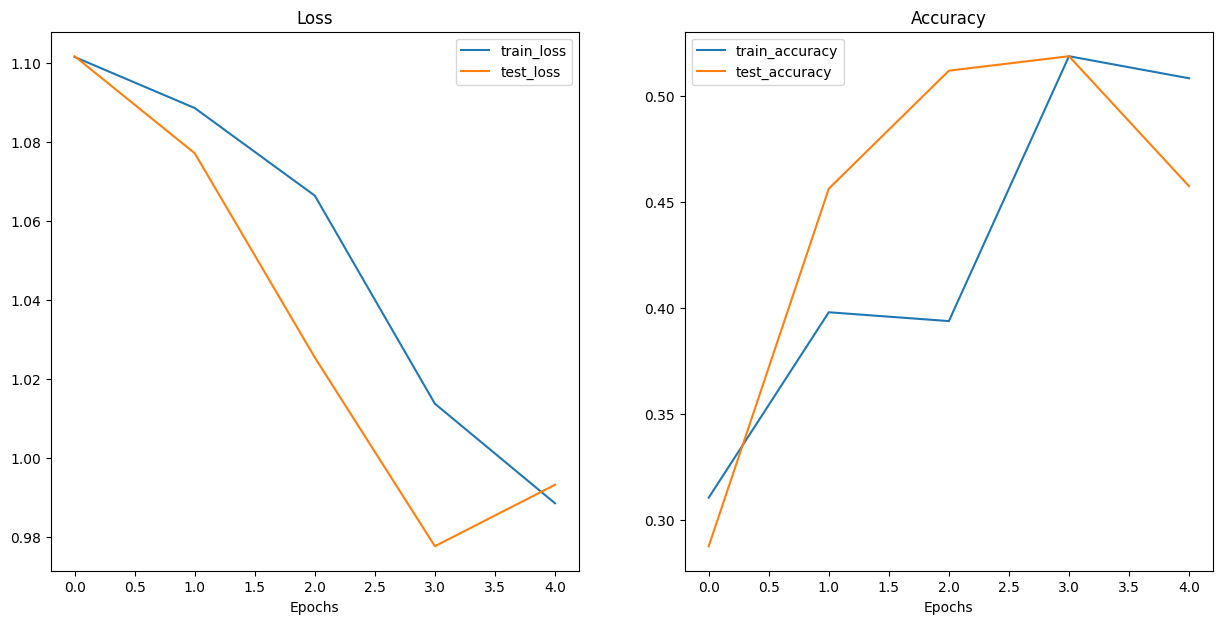

In [67]:
plot_loss_curves(model_1_results)

### **10. Compare model results**


In [68]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.104658,0.314583,1.097167,0.287500
1,1.088572,0.397917,1.073923,0.428977
2,1.055298,0.493750,1.040929,0.472727
3,0.982474,0.533333,0.978214,0.545455
4,0.982100,0.485417,0.934752,0.550568


### **11. Making prediction on a custom image**

Although we've trained a model on custom data, how can we make a prediction a sample or image thats not in eitheir training or testing dataset


In [69]:
# Download custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data\04-pizza-dad.jpeg already exists, skipping download.


### **11.1 Loading in a custom image with PyTorch**

We have to ensure that our custom image is in the same format as data our model was trained on.

* In tensor form with datatype (torch.float(32))
* Of shape 64x64x3
* On the right device


In [70]:
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [71]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### **11.2 Predicting on custom images with a trained PyTorch Model**

(-0.5, 3023.5, 4031.5, -0.5)

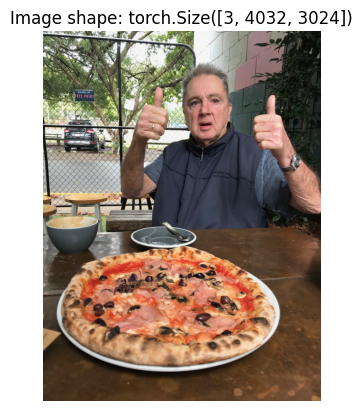

In [72]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [73]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [74]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [75]:
custom_image_pred

tensor([[-0.0850, -0.3034,  0.2063]])

In [76]:
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.0850, -0.3034,  0.2063]])
Prediction probabilities: tensor([[0.3183, 0.2558, 0.4259]])
Prediction label: tensor([2])


### **11.3 Putting custom image prediction together: building a function**


Let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

In [77]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    target_image = target_image / 255. 
    
    if transform:
        target_image = transform(target_image)
    
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
        
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

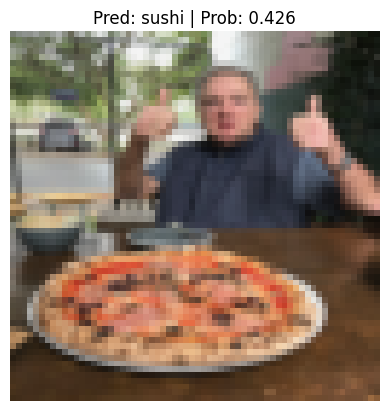

In [78]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)